In [1]:
import seaborn as sns
import csv
import optuna
import optuna.integration.lightgbm as lgb
import itertools, logging, joblib
import networkx as nx
NOTE_NAME = "lgbm2"

In [2]:
ROUND = "237"
TOURNAMENT_NAME = "kazutsugi"
TARGET_NAME = f"target_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"
N_FEATURE = 310

In [4]:
# Load Dataset
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)
    return df

train = read_csv("../../dataset/numerai_dataset_237/numerai_training_data.csv")
tournament = read_csv("../../dataset/numerai_dataset_237/numerai_tournament_data.csv")

# reform
train.sort_index(axis=1, inplace=True)
tournament.sort_index(axis=1, inplace=True)
cols_feature = train.columns[train.columns.str.contains("feature_")]
cols_target  = train.columns[train.columns.str.contains("target_")]

In [5]:
train.head(1).append(tournament.tail(1))

,data_type,era,feature_charisma1,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma2,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma3,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma4,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma5,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma6,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma7,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma8,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,feature_charisma9,feature_constitution1,feature_constitution10,feature_constitution100,feature_constitution101,feature_constitution102,feature_constitution103,feature_constitution104,feature_constitution105,feature_constitution106,feature_constitution107,feature_constitution108,feature_constitution109,feature_constitution11,feature_constitution110,feature_constitution111,feature_constitution112,feature_constitution113,feature_constitution114,feature_constitution12,feature_constitution13,feature_constitution14,feature_constitution15,feature_constitution16,feature_constitution17,feature_constitution18,feature_constitution19,feature_constitution2,feature_constitution20,feature_constitution21,feature_constitution22,feature_constitution23,feature_constitution24,feature_constitution25,feature_constitution26,feature_constitution27,feature_constitution28,feature_constitution29,feature_constitution3,feature_constitution30,feature_constitution31,feature_constitution32,feature_constitution33,feature_constitution34,feature_constitution35,feature_constitution36,feature_constitution37,feature_constitution38,feature_constitution39,feature_constitution4,feature_constitution40,feature_constitution41,feature_constitution42,feature_constitution43,feature_constitution44,feature_constitution45,feature_constitution46,feature_constitution47,feature_constitution48,feature_constitution49,feature_constitution5,feature_constitution50,feature_constitution51,feature_constitution52,feature_constitution53,feature_constitution54,feature_constitution55,feature_constitution56,feature_constitution57,feature_constitution58,feature_constitution59,feature_constitution6,feature_constitution60,feature_constitution61,feature_constitution62,feature_constitution63,feature_constitution64,feature_constitution65,feature_constitution66,feature_constitution67,feature_constitution68,feature_constitution69,feature_constitution7,feature_constitution70,feature_constitution71,feature_constitution72,feature_constitution73,feature_constitution74,feature_constitution75,feature_constitution76,feature_constitution77,feature_constitution78,feature_constitution79,feature_constitution8,feature_constitution80,feature_constitution81,feature_constitution82,feature_constitution83,feature_constitution84,feature_constitution85,feature_constitution86,feature_constitution87,feature_constitution88,feature

In [11]:
model = joblib.load(f"{NOTE_NAME}/ensemble_lgb.pkl")
signals = pd.read_csv(f"{NOTE_NAME}/ensemble_pred.csv").set_index("id")
val_signals = pd.read_csv(f"{NOTE_NAME}/ensemble_pred_val.csv").set_index("id")

-----  
## 各モデルのFeatureImportance, FeatureExposure

In [6]:
from scipy.stats import spearmanr
def calcFeatureExposure(X:pd.DataFrame, pred:np.ndarray)->pd.Series:
    # pred: np.array
    exposures = [spearmanr(pred, X[col])[0] for col in X.columns]
    return pd.Series(exposures, index=X.columns)

In [16]:
# featureExpとfeatureImpを計算
fi = pd.Series(model.feature_importance(), index=model.feature_name()).to_frame(f"fi")
fe = calcFeatureExposure(train.loc[:, cols_feature], signals.values).to_frame(f"fe")
fe["feature_category"] = fe.index.str.replace("[0-9]","").str.replace("feature_","")

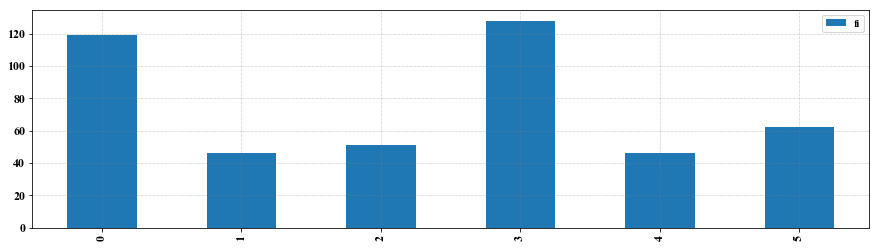

In [22]:
# feature importance model別
fi.plot.bar(figsize=(15, 4)); 

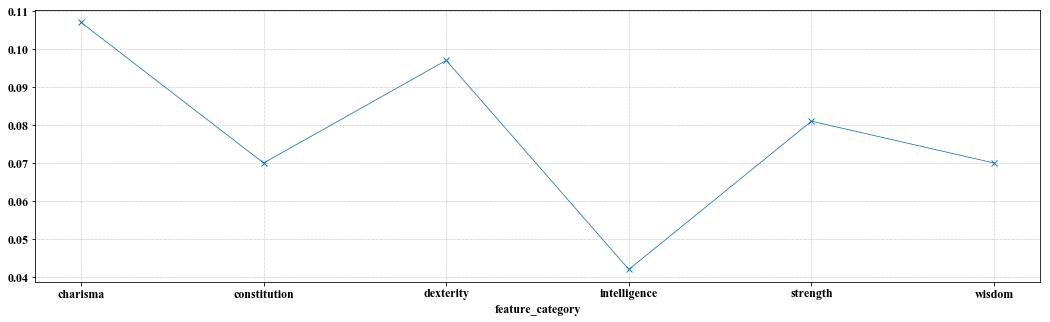

In [29]:
# category別 平均 feature exposure
fe.fe.abs().groupby(fe.feature_category).mean().round(3).plot(figsize=(18,5), marker="x")

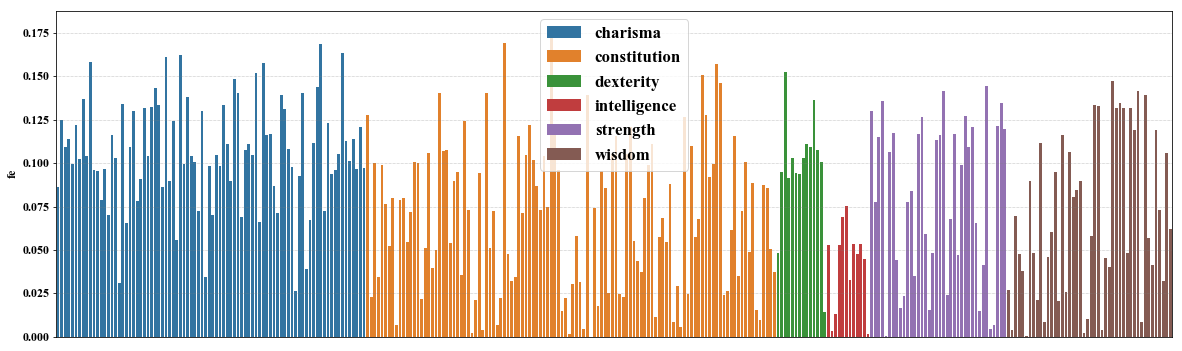

In [39]:
plt.figure(figsize=(20, 6))
sns.barplot(x=fe.index, y=fe.fe.abs(), data=fe, hue="feature_category", dodge=False);
plt.xticks([]); plt.legend(fontsize=17);

featureExpが綺麗にばらけている  
綺麗にばらけすぎでは  
overfit説

----  
## outputの評価

In [40]:
example_preds = \
    pd.read_csv(f"../../dataset/numerai_dataset_237/example_predictions_target_kazutsugi.csv")\
    .set_index("id").loc[tournament.index]

In [44]:
# signal
signals = pd.read_csv(f"{NOTE_NAME}/ensemble_pred.csv").set_index("id")
signals = signals.join(train.era).join(train[TARGET_NAME])
signals["eraNum"] = signals.era.str.slice(3).astype(int)
signals = signals.join(example_preds)

val_signals = pd.read_csv(f"{NOTE_NAME}/ensemble_pred_val.csv").set_index("id")
val_signals = val_signals.join(tournament.era).join(tournament[TARGET_NAME]).dropna()
val_signals["eraNum"] = val_signals.era.str.slice(3).astype(int)
val_signals = val_signals.join(example_preds.dropna())

---  
model別 CORR score

In [46]:
# Submissions are scored by spearman correlation
def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [50]:
# era毎にcorr計算
corr = pd.concat([signals.groupby("eraNum").apply(calcRankCorr(i)) for i in ["pred"]], axis=1)
val_corr = pd.concat([val_signals.groupby("eraNum").apply(calcRankCorr(i)) for i in ["pred", PREDICTION_NAME]], axis=1)

In [51]:
# in sample score
corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0
mean,0.152293
std,0.028825
<lambda>,5.283274


In [52]:
# validation sample score
val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1
mean,0.032224,0.028878
std,0.025189,0.030828
<lambda>,1.279288,0.936728


validation sharpeはexampleを上回っているが, model構築フローミスっているのでoverfit説...  
(validation lossが最小となるmodelsを validation loss を最小にするようにensembleしている)

---  
Neutralize後のモデル別 CORR score

In [53]:
def neutralize(df, columns, by, proportion=1.0):
    scores = df.loc[:, columns]
    exposures = df[by].values

    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack(
        (exposures,
         np.asarray(np.mean(scores)) * np.ones(len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(
        np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()

def calcRankCorr(i):
    def _main(df):
        ranked_preds = df[i].rank(pct=True, method="first")
        return np.corrcoef(ranked_preds, df[TARGET_NAME])[0, 1]
    return _main

In [54]:
# neutralized signals
nSignals = pd.concat([neutralize(train.join(signals[[i]]).dropna(), [i], cols_feature) for i in ["pred"]], axis=1)
nSignals = nSignals.join(train.era).join(train[TARGET_NAME])
nSignals["eraNum"] = nSignals.era.str.slice(3).astype(int)

val_nSignals = pd.concat([neutralize(tournament.join(val_signals[[i]]).dropna(), [i], cols_feature) for i in ["pred"]], axis=1)
val_nSignals = val_nSignals.join(tournament.era).join(tournament[TARGET_NAME])
val_nSignals["eraNum"] = val_nSignals.era.str.slice(3).astype(int)

In [55]:
# era毎にneutralized_corr計算
neutralized_corr = pd.concat([nSignals.groupby("eraNum").apply(calcRankCorr(i)) for i in ["pred"]], axis=1)
val_neutralized_corr = pd.concat([val_nSignals.groupby("eraNum").apply(calcRankCorr(i)) for i in ["pred"]], axis=1)

**Training sample**

In [56]:
neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0
mean,0.160030
std,0.021770
<lambda>,7.350787


In [57]:
# 差分
neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]) - corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0
mean,0.007738
std,-0.007055
<lambda>,2.067513


**Valiation sample**

In [58]:
val_neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])  # neutralized

,0
mean,0.031220
std,0.021013
<lambda>,1.485774


In [59]:
# 差分
val_neutralized_corr.agg(["mean", "std", lambda x: x.mean()/x.std()]) - val_corr.agg(["mean", "std", lambda x: x.mean()/x.std()])

,0,1
mean,-0.001004,NaN
std,-0.004176,NaN
<lambda>,0.206485,NaN


さらにsharpeが上がる

---  
MMC (validationのみ)

In [60]:
# MMC over validation
def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))
    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized

corrs = pd.DataFrame(); mmcs = pd.DataFrame()
for model_id in ["pred"]:
    mmc_scores = []
    corr_scores = []
    for _, x in val_signals.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[model_id])), pd.Series(unif(x[PREDICTION_NAME])))
        mmc_scores.append( np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2) )
        corr_scores.append( correlation(unif(x[model_id]), x[TARGET_NAME]) )
    mmcs.loc[:, model_id] = mmc_scores
    corrs.loc[:, model_id] = corr_scores

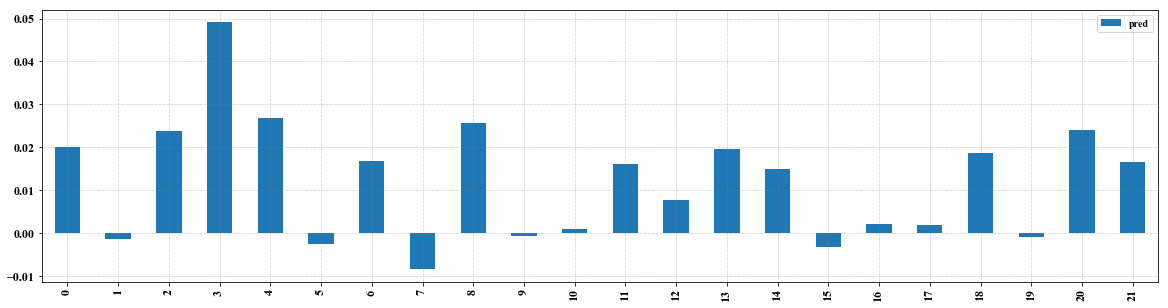

In [61]:
mmcs.plot.bar(figsize=(20, 5));

In [62]:
mmcs.agg(["mean", "std", lambda x: x.mean()/x.std()])

,pred
mean,0.012151
std,0.013851
<lambda>,0.877257


In [63]:
(mmcs+corrs).agg(["mean", "std", lambda x: x.mean()/x.std()])

,pred
mean,0.044375
std,0.032721
<lambda>,1.356175


ensembleモデルのパフォーマンスが最も良いが, overfit説拭えず.  
ただ上手く行く可能性も拭えず.
最新データセットでもう一度trainしてlaunch.